In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import random

In [3]:
# 🔹 Configuration Parameters
SAMPLING_RATE = 128  # Hz
LOWCUT = 0.5  # Hz
HIGHCUT = 3.0  # Hz
WINDOW_SIZE = 30  # seconds
CALIBRATION_TIME = 3


In [5]:
WORDS = ["RED", "GREEN", "BLUE", "YELLOW", "PURPLE"]
COLORS = {"RED": "red", "GREEN": "green", "BLUE": "blue", "YELLOW": "yellow", "PURPLE": "purple"}
MATCH_PROBABILITY=0.3
color=[]
word=[]
result = [True] * int(120*MATCH_PROBABILITY) + [False] * int(120-(120*MATCH_PROBABILITY))
random.shuffle(result)
for i in range(120):
    is_match = result[i]
    current_word = random.choice(WORDS)
    correct_color = COLORS[current_word]

    if is_match:
        current_color = correct_color
    else:
        other_colors = [c for c in COLORS.values() if c != correct_color]
        current_color = random.choice(other_colors)
    color.append(current_color)
    word.append(current_word)

In [12]:
pd.DataFrame({"word": np.array(word), "color": np.array(color)}, columns=["word","color"]).to_csv("stroop.txt", index=False)

In [3]:
file_path = "./data/test/participant_test_ppg_data.csv"
data = pd.read_csv(file_path)

time = data.iloc[:, 0].values
ppg_signal = data.iloc[:, 1].values

print(len(data)/data['Time(s)'].iloc[-1])

512.5817195016652


In [5]:
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [14]:
filtered_ppg = bandpass_filter(ppg_signal, LOWCUT, HIGHCUT, SAMPLING_RATE)

In [15]:
window_samples = WINDOW_SIZE * SAMPLING_RATE
num_windows = len(ppg_signal) // window_samples
hr_times = []
hr_values = []

for i in range(num_windows):
    start = i * window_samples
    end = start + window_samples
    segment = filtered_ppg[start:end]
    segment_time = time[start:end]

    # Detect peaks
    peaks, _ = find_peaks(segment, distance=SAMPLING_RATE // 2, prominence=0.3)
    peak_times = segment_time[peaks]
    peak_intervals = np.diff(peak_times)

    if len(peak_intervals) > 0:
        avg_interval = np.mean(peak_intervals)
        heart_rate = 60 / avg_interval
    else:
        heart_rate = np.nan

    hr_times.append(segment_time[len(segment_time) // 2])
    hr_values.append(heart_rate)

In [21]:
period_labels = []
for t in hr_times:
    if t < 140:
        period_labels.append('Stroop 1')
    elif t < 395:
        period_labels.append('Meditation')
    else:
        period_labels.append('Stroop 2')


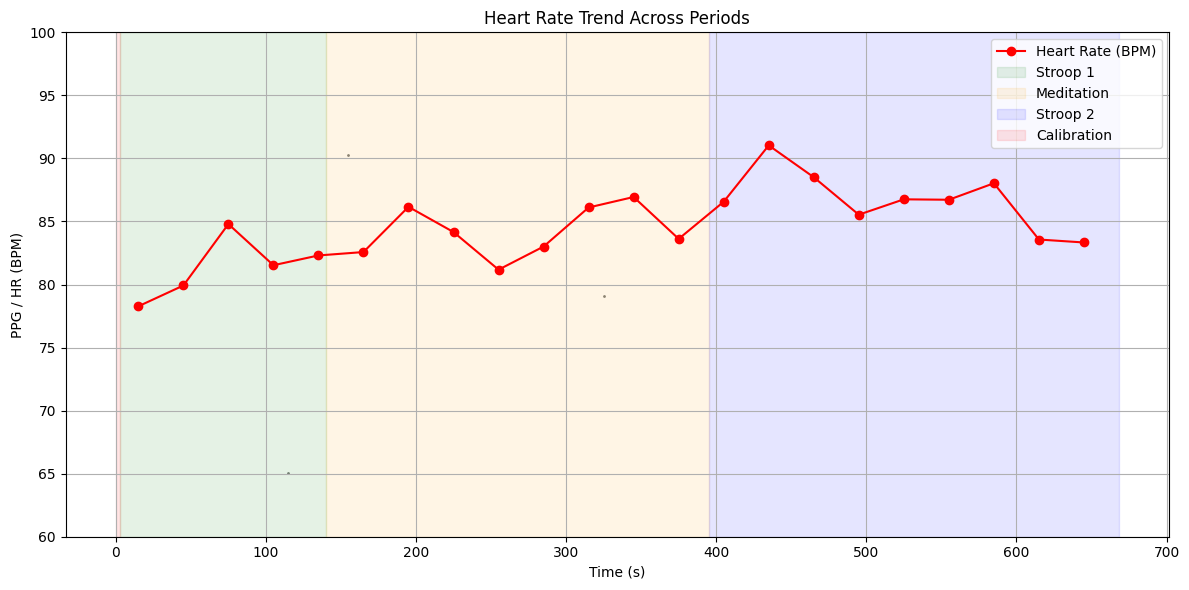

In [19]:
plt.figure(figsize=(12, 6))
# plt.plot(time, filtered_ppg, color='lightgray', label='Filtered PPG Signal')
plt.scatter(time[::SAMPLING_RATE*5], filtered_ppg[::SAMPLING_RATE*5], s=1, color='gray')

plt.plot(hr_times, hr_values, 'ro-', label='Heart Rate (BPM)')
plt.axvspan(CALIBRATION_TIME, 140, color='green', alpha=0.1, label='Stroop 1')
plt.axvspan(140, 395, color='orange', alpha=0.1, label='Meditation')
plt.axvspan(395, time[-1], color='blue', alpha=0.1, label='Stroop 2')
plt.axvspan(0, CALIBRATION_TIME, color='red', alpha=0.1, label='Calibration')

plt.xlabel('Time (s)')
plt.ylabel('PPG / HR (BPM)')
plt.ylim(60, 100)
plt.title('Heart Rate Trend Across Periods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
summary = pd.DataFrame({'Time': hr_times, 'Heart Rate (BPM)': hr_values, 'Period': period_labels})
period_stats = summary.groupby('Period')['Heart Rate (BPM)'].agg(['mean', 'std', 'count'])
print("\n📊 Period-wise Heart Rate Summary:")
print(period_stats)


📊 Period-wise Heart Rate Summary:
                 mean       std  count
Period                                
Meditation  84.219593  2.018899      8
Stroop 1    81.365283  2.465411      5
Stroop 2    86.673940  2.406548      9


In [28]:
# Load the CSV files
before_df = pd.read_csv('./data/audio/participant_2_stroop_results_before.csv')
after_df = pd.read_csv('./data/audio/participant_2_stroop_results_after.csv')

# Analysis function
def analyze_stroop(df):
    total_trials = len(df)
    correct_trials = df['correct'].sum()
    accuracy = correct_trials / total_trials * 100

    valid_reactions = df[(df['correct'] == True) & (df['reaction_time'].notna())]
    avg_reaction_time = valid_reactions['reaction_time'].mean()

    match_group = df.groupby('match').agg(
        accuracy=('correct', 'mean'),
        avg_reaction_time=('reaction_time', 'mean')
    ) * 100

    return {
        "Total Trials": total_trials,
        "Correct Trials": correct_trials,
        "Accuracy (%)": accuracy,
        "Average Reaction Time (s)": avg_reaction_time,
        "Match Condition Analysis": match_group
    }


In [30]:
# Run analysis
before_analysis = analyze_stroop(before_df)
after_analysis = analyze_stroop(after_df)

# Print Summary
print("=== Stroop Task Analysis ===\n")
print("Before Intervention:")
print(f"Total Trials: {before_analysis['Total Trials']}")
print(f"Correct Trials: {before_analysis['Correct Trials']}")
print(f"Accuracy: {before_analysis['Accuracy (%)']:.2f}%")
print(f"Average Reaction Time: {before_analysis['Average Reaction Time (s)']:.3f} s")
print("\nAccuracy & RT by Match Condition:")
print(before_analysis['Match Condition Analysis'])

print("\nAfter Intervention:")
print(f"Total Trials: {after_analysis['Total Trials']}")
print(f"Correct Trials: {after_analysis['Correct Trials']}")
print(f"Accuracy: {after_analysis['Accuracy (%)']:.2f}%")
print(f"Average Reaction Time: {after_analysis['Average Reaction Time (s)']:.3f} s")
print("\nAccuracy & RT by Match Condition:")
print(after_analysis['Match Condition Analysis'])

# Visualization
labels = ['Before', 'After']
accuracy = [before_analysis['Accuracy (%)'], after_analysis['Accuracy (%)']]
reaction_times = [before_analysis['Average Reaction Time (s)'], after_analysis['Average Reaction Time (s)']]


=== Stroop Task Analysis ===

Before Intervention:
Total Trials: 80
Correct Trials: 73
Accuracy: 91.25%
Average Reaction Time: 0.777 s

Accuracy & RT by Match Condition:
        accuracy  avg_reaction_time
match                              
False  96.226415          92.250000
True   81.481481          77.695455

After Intervention:
Total Trials: 80
Correct Trials: 76
Accuracy: 95.00%
Average Reaction Time: 0.735 s

Accuracy & RT by Match Condition:
        accuracy  avg_reaction_time
match                              
False  95.744681          67.750000
True   93.939394          73.490323
